<a href="https://colab.research.google.com/github/DiegoSnach/The-final-project-GLUE/blob/master/2_FINAL_SST2_with_GLove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from time import time
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
import os
import numpy as np

import tensorflow as tf 
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


GPU is available


In [ ]:
# if `batch_size=-1`, will return the full dataset as `tf.tensor`s. ABSOLUTELY FUNDAMENTAL!

train_data, validation_data = tfds.load(name='glue/sst2', split=['train', 'validation'], batch_size=-1)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incomplete3A16TL/glue-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incomplete3A16TL/glue-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incomplete3A16TL/glue-test.tfrecord


Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/sst2/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_data.keys()

dict_keys(['idx', 'label', 'sentence'])

In [ ]:
df_train = pd.DataFrame(data=train_data)
df_val = pd.DataFrame(data=validation_data)

In [ ]:
df_train.loc[df_train['label']==0]

,idx,label,sentence
0,16399,0,b'for the uninitiated plays better on video wi...
1,1680,0,b'like a giant commercial for universal studio...
4,27051,0,"b', this cross-cultural soap opera is painfull..."
6,54784,0,b'only masochistic moviegoers need apply . '
10,1456,0,b'revelatory nor truly edgy -- merely crassly ...
...,...,...,...
67342,32150,0,"b""too much ai n't - she-cute baggage into her ..."
67343,47134,0,"b'despite some charm and heart , this quirky s..."
67344,10487,0,b'even worse than its title '
67347,32842,0,b'the very definition of what critics have com...


In [ ]:
# Creates function to clean data

def process_data (data):
  punct = "/-?!.,#$%\()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
  def clean_the_text (text, punt):
    for p in punct:
      text = text.replace(p, ' ')
      text = text.replace("b'", ' ', 1)
      text = text.replace('b"', ' ', 1)
    return text
  
  data =  data.astype(str).apply(lambda x: clean_the_text(x, punct))
  return data  
 

In [ ]:
# Transform data to string as it came as tensor object. Cleans data

sentence = process_data(df_train.sentence.apply(str))
label = df_train.label.apply(int)
print(len(sentence))
print(len(label))

67349
67349


In [ ]:
sentence

0         for the uninitiated plays better on video wit...
1         like a giant commercial for universal studios...
2               company once again dazzle and delight us '
3         's no surprise that as a director washington ...
4           this cross cultural soap opera is painfully...
                               ...                        
67344                          even worse than its title '
67345     an indispensable peek at the art and the agon...
67346                                       more playful '
67347     the very definition of what critics have come...
67348                           barn burningly bad movie '
Name: sentence, Length: 67349, dtype: object

In [ ]:
# Transform data to string for validation as well

val_sentence = process_data(df_val.sentence.apply(str))
val_label = df_val.label
print(len(val_sentence))
print(len(val_label))

872
872


In [ ]:
# Check lenght of sentence

count = sentence.apply(lambda x: len(str(x).split()))
print('Mean: %f' % (count.mean()))
print('Median: %f' % (count.median()))
print('Max: %f' % (count.max()))

Mean: 9.722876
Median: 7.000000
Max: 49.000000


In [ ]:
# Brings Tokenizer and sequences padder

Tokenizer = tf.keras.preprocessing.text.Tokenizer
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences

tokenizer = Tokenizer(num_words=20000)
max_len = 32

In [ ]:
# Creates vocabulary with all unique tokens

tokenizer.fit_on_texts(list(sentence) + list(val_sentence))
vocab_size = len(tokenizer.word_index) + 1 # Because it counts from 0
print(vocab_size)

14651


In [ ]:
# transforms sentences into integers and pads to maxlen

encoded_sentences = tokenizer.texts_to_sequences(sentence)
padded_sentences = pad_sequences(encoded_sentences, maxlen=max_len, padding='post')

# Check
print(sentence[0])
print(encoded_sentences[0])
print(padded_sentences[0])

 for the uninitiated plays better on video with the sound '
[16, 2, 11788, 551, 119, 23, 278, 13, 2, 1212, 1]
[   16     2 11788   551   119    23   278    13     2  1212     1     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [ ]:
# Same for validation

val_encoded_sentences = tokenizer.texts_to_sequences(val_sentence)
val_padded_sentences = pad_sequences(val_encoded_sentences, maxlen=max_len, padding='post')

# Check
print(val_sentence[0])
print(val_encoded_sentences[0])
print(val_padded_sentences[0])

 a valueless kiddie paean to pro basketball underwritten by the nba   '
[3, 13869, 1430, 8345, 6, 4737, 4851, 13870, 25, 2, 7587, 1]
[    3 13869  1430  8345     6  4737  4851 13870    25     2  7587     1
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [ ]:
# # download pretrained GloVe embeddings

# !wget http://nlp.stanford.edu/data/glove.6B.zip

# !unzip glove.6B.zip

In [ ]:
# Mount them from drive for quicker performance

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# lists files

!ls "/content/gdrive/My Drive/Glove/glove.6B.300d.txt"

'/content/gdrive/My Drive/Glove/glove.6B.300d.txt'


In [ ]:
# Creates dictionary of word embeddings

glove_dir = './'

embeddings_index = {} #initialize dictionary
f = open(os.path.join('/content/gdrive/My Drive/Glove/glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# Start with the embedding. Randomly initializing the zeros

embedding_dimensions = 300

embedding_matrix = np.zeros((vocab_size, embedding_dimensions))

for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector  

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, SpatialDropout1D
from keras import layers

In [ ]:
embed = Embedding(vocab_size,embedding_dimensions,weights=[embedding_matrix],input_length=max_len, trainable=False)

n_hidden = 50


In [ ]:
model = Sequential()
model.add(embed)
model.add(LSTM(n_hidden, dropout=0.2, activation='tanh', recurrent_dropout=0.2))
preds = model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 300)           4395300   
_________________________________________________________________
lstm (LSTM)                  (None, 50)                70200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 4,465,551
Trainable params: 70,251
Non-trainable params: 4,395,300
_________________________________________________________________


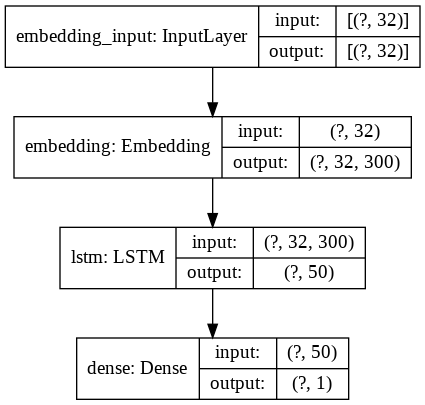

In [ ]:
# Plot model graph
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [ ]:
# Early stopping to prevent under/over fitting
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='auto')

history = model.fit(padded_sentences,
                    label,                    
                    epochs=10,
                    batch_size=128,                                        
                    validation_split = 0.2,
                    verbose=True,              
                    callbacks=[earlystop])

Epoch 1/10
421/421 [==============================] - 45s 108ms/step - loss: 0.4698 - accuracy: 0.7809 - val_loss: 0.3589 - val_accuracy: 0.8426
Epoch 2/10
421/421 [==============================] - 45s 107ms/step - loss: 0.3268 - accuracy: 0.8587 - val_loss: 0.2864 - val_accuracy: 0.8820
Epoch 3/10
421/421 [==============================] - 45s 107ms/step - loss: 0.2797 - accuracy: 0.8833 - val_loss: 0.2585 - val_accuracy: 0.8959
Epoch 4/10
421/421 [==============================] - 45s 106ms/step - loss: 0.2535 - accuracy: 0.8957 - val_loss: 0.2409 - val_accuracy: 0.9076
Epoch 5/10
421/421 [==============================] - 44s 106ms/step - loss: 0.2370 - accuracy: 0.9031 - val_loss: 0.2385 - val_accuracy: 0.9069
Epoch 6/10
421/421 [==============================] - 45s 106ms/step - loss: 0.2236 - accuracy: 0.9095 - val_loss: 0.2299 - val_accuracy: 0.9118
Epoch 7/10
421/421 [==============================] - 45s 106ms/step - loss: 0.2160 - accuracy: 0.9139 - val_loss: 0.2319 - val_ac

In [ ]:
# Uncomment and start again from Sequential to 
# Reset weights and retrain model

# K.clear_session()
# tf.keras.backend.clear_session()

In [ ]:
# Test evaluation
print("Evaluate on test data")

results = model.evaluate(val_padded_sentences, val_label, batch_size=32)
print("test loss, test acc:", results)

Evaluate on test data
28/28 [==============================] - 0s 9ms/step - loss: 0.4644 - accuracy: 0.8291
test loss, test acc: [0.46439775824546814, 0.8291284441947937]


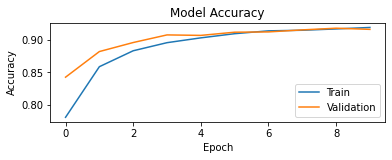

In [ ]:
import seaborn as sns


# Plot Accuracy

plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')

In [ ]:
def make_model():
  tf.keras.backend.clear_session() # Starts session from scratch
  print('New experiment')
  model = Sequential()
  model.add(embed)
  model.add(LSTM(n_hidden, dropout=0.2, activation='tanh', recurrent_dropout=0.2))
  model.add(Dense(1, activation='sigmoid'))
  # model.summary()
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                loss=tf.keras.losses.binary_crossentropy, 
                metrics=['accuracy'])
  model.fit(padded_sentences, 
            label, 
            epochs=10, 
            batch_size=128,            
            validation_split = 0.2, 
            verbose=2, 
            callbacks=[earlystop])
  results2 = model.evaluate(val_padded_sentences, val_label)  
  return results2

In [ ]:
colection = [make_model() for _ in range (10)]

New experiment


Epoch 1/10
421/421 - 47s - loss: 0.6214 - accuracy: 0.6473 - val_loss: 0.4740 - val_accuracy: 0.7961
Epoch 2/10
421/421 - 47s - loss: 0.3948 - accuracy: 0.8260 - val_loss: 0.3238 - val_accuracy: 0.8630
Epoch 3/10
421/421 - 47s - loss: 0.3208 - accuracy: 0.8620 - val_loss: 0.2889 - val_accuracy: 0.8820
Epoch 4/10
421/421 - 47s - loss: 0.2864 - accuracy: 0.8803 - val_loss: 0.2720 - val_accuracy: 0.8907
Epoch 5/10
421/421 - 47s - loss: 0.2659 - accuracy: 0.8918 - val_loss: 0.2507 - val_accuracy: 0.9010
Epoch 6/10
421/421 - 47s - loss: 0.2480 - accuracy: 0.8980 - val_loss: 0.2453 - val_accuracy: 0.9029
Epoch 7/10
421/421 - 47s - loss: 0.2403 - accuracy: 0.9021 - val_loss: 0.2418 - val_accuracy: 0.9059
Epoch 8/10
421/421 - 46s - loss: 0.2316 - accuracy: 0.9068 - val_loss: 0.2469 - val_accuracy: 0.9068
Epoch 9/10
421/421 - 47s - loss: 0.2252 - accuracy: 0.9100 - val_loss: 0.2368 - val_accuracy: 0.9097
Epoch 10/10
421/421 - 47s - loss: 0.2214 - accuracy: 0.9120 - val_loss: 0.2278 - val_accura

Epoch 1/10
421/421 - 47s - loss: 0.6313 - accuracy: 0.6357 - val_loss: 0.4438 - val_accuracy: 0.8020
Epoch 2/10
421/421 - 47s - loss: 0.3925 - accuracy: 0.8267 - val_loss: 0.3288 - val_accuracy: 0.8601
Epoch 3/10
421/421 - 47s - loss: 0.3226 - accuracy: 0.8615 - val_loss: 0.2897 - val_accuracy: 0.8780
Epoch 4/10
421/421 - 47s - loss: 0.2871 - accuracy: 0.8810 - val_loss: 0.2614 - val_accuracy: 0.8945
Epoch 5/10
421/421 - 47s - loss: 0.2704 - accuracy: 0.8887 - val_loss: 0.2725 - val_accuracy: 0.8881
Epoch 6/10
421/421 - 47s - loss: 0.2495 - accuracy: 0.8989 - val_loss: 0.2414 - val_accuracy: 0.9042
Epoch 7/10
421/421 - 47s - loss: 0.2374 - accuracy: 0.9045 - val_loss: 0.2407 - val_accuracy: 0.9082
Epoch 8/10
421/421 - 47s - loss: 0.2282 - accuracy: 0.9079 - val_loss: 0.2317 - val_accuracy: 0.9120
Epoch 9/10
421/421 - 47s - loss: 0.2239 - accuracy: 0.9092 - val_loss: 0.2274 - val_accuracy: 0.9136
Epoch 10/10
421/421 - 47s - loss: 0.2157 - accuracy: 0.9141 - val_loss: 0.2243 - val_accura

Epoch 1/10
421/421 - 47s - loss: 0.6789 - accuracy: 0.5612 - val_loss: 0.6861 - val_accuracy: 0.5586
Epoch 2/10
421/421 - 47s - loss: 0.4251 - accuracy: 0.7993 - val_loss: 0.3310 - val_accuracy: 0.8593
Epoch 3/10
421/421 - 47s - loss: 0.3063 - accuracy: 0.8709 - val_loss: 0.2791 - val_accuracy: 0.8860
Epoch 4/10
421/421 - 47s - loss: 0.2747 - accuracy: 0.8862 - val_loss: 0.2699 - val_accuracy: 0.8886
Epoch 5/10
421/421 - 47s - loss: 0.2522 - accuracy: 0.8973 - val_loss: 0.2500 - val_accuracy: 0.9014
Epoch 6/10
421/421 - 47s - loss: 0.2383 - accuracy: 0.9021 - val_loss: 0.2417 - val_accuracy: 0.9033
Epoch 7/10
421/421 - 47s - loss: 0.2294 - accuracy: 0.9066 - val_loss: 0.2331 - val_accuracy: 0.9086
Epoch 8/10
421/421 - 46s - loss: 0.2215 - accuracy: 0.9115 - val_loss: 0.2265 - val_accuracy: 0.9148
Epoch 9/10
421/421 - 46s - loss: 0.2149 - accuracy: 0.9142 - val_loss: 0.2293 - val_accuracy: 0.9137
Epoch 10/10
421/421 - 46s - loss: 0.2120 - accuracy: 0.9161 - val_loss: 0.2313 - val_accura

Epoch 1/10
421/421 - 45s - loss: 0.5341 - accuracy: 0.7351 - val_loss: 0.3994 - val_accuracy: 0.8324
Epoch 2/10
421/421 - 47s - loss: 0.3934 - accuracy: 0.8297 - val_loss: 0.3389 - val_accuracy: 0.8594
Epoch 3/10
421/421 - 47s - loss: 0.3388 - accuracy: 0.8551 - val_loss: 0.3029 - val_accuracy: 0.8731
Epoch 4/10
421/421 - 46s - loss: 0.3035 - accuracy: 0.8723 - val_loss: 0.2682 - val_accuracy: 0.8912
Epoch 5/10
421/421 - 46s - loss: 0.2747 - accuracy: 0.8870 - val_loss: 0.2527 - val_accuracy: 0.9007
Epoch 6/10
421/421 - 46s - loss: 0.2591 - accuracy: 0.8924 - val_loss: 0.2439 - val_accuracy: 0.9036
Epoch 7/10
421/421 - 45s - loss: 0.2439 - accuracy: 0.8999 - val_loss: 0.2385 - val_accuracy: 0.9079
Epoch 8/10
421/421 - 45s - loss: 0.2341 - accuracy: 0.9058 - val_loss: 0.2350 - val_accuracy: 0.9089
Epoch 9/10
421/421 - 45s - loss: 0.2255 - accuracy: 0.9094 - val_loss: 0.2490 - val_accuracy: 0.9022
Epoch 10/10
421/421 - 45s - loss: 0.2232 - accuracy: 0.9105 - val_loss: 0.2286 - val_accura

Epoch 1/10
421/421 - 45s - loss: 0.4001 - accuracy: 0.8195 - val_loss: 0.3113 - val_accuracy: 0.8710
Epoch 2/10
421/421 - 44s - loss: 0.2964 - accuracy: 0.8742 - val_loss: 0.2720 - val_accuracy: 0.8892
Epoch 3/10
421/421 - 44s - loss: 0.2577 - accuracy: 0.8939 - val_loss: 0.2425 - val_accuracy: 0.9037
Epoch 4/10
421/421 - 44s - loss: 0.2377 - accuracy: 0.9019 - val_loss: 0.2376 - val_accuracy: 0.9093
Epoch 5/10
421/421 - 45s - loss: 0.2225 - accuracy: 0.9104 - val_loss: 0.2301 - val_accuracy: 0.9113
Epoch 6/10
421/421 - 45s - loss: 0.2140 - accuracy: 0.9139 - val_loss: 0.2383 - val_accuracy: 0.9114
Epoch 7/10
421/421 - 45s - loss: 0.2069 - accuracy: 0.9174 - val_loss: 0.2201 - val_accuracy: 0.9184
Epoch 8/10
421/421 - 44s - loss: 0.2009 - accuracy: 0.9185 - val_loss: 0.2214 - val_accuracy: 0.9167
Epoch 9/10
421/421 - 44s - loss: 0.1946 - accuracy: 0.9232 - val_loss: 0.2256 - val_accuracy: 0.9155
Epoch 10/10
421/421 - 43s - loss: 0.1920 - accuracy: 0.9232 - val_loss: 0.2213 - val_accura

Epoch 1/10
421/421 - 44s - loss: 0.6691 - accuracy: 0.5879 - val_loss: 0.6701 - val_accuracy: 0.5837
Epoch 2/10
421/421 - 44s - loss: 0.4916 - accuracy: 0.7532 - val_loss: 0.3638 - val_accuracy: 0.8463
Epoch 3/10
421/421 - 44s - loss: 0.3577 - accuracy: 0.8480 - val_loss: 0.3161 - val_accuracy: 0.8689
Epoch 4/10
421/421 - 44s - loss: 0.3195 - accuracy: 0.8650 - val_loss: 0.2833 - val_accuracy: 0.8866
Epoch 5/10
421/421 - 43s - loss: 0.2877 - accuracy: 0.8809 - val_loss: 0.2685 - val_accuracy: 0.8915
Epoch 6/10
421/421 - 44s - loss: 0.2681 - accuracy: 0.8904 - val_loss: 0.2538 - val_accuracy: 0.9011
Epoch 7/10
421/421 - 44s - loss: 0.2509 - accuracy: 0.8967 - val_loss: 0.2439 - val_accuracy: 0.9059
Epoch 8/10
421/421 - 44s - loss: 0.2380 - accuracy: 0.9038 - val_loss: 0.2341 - val_accuracy: 0.9086
Epoch 9/10
421/421 - 43s - loss: 0.2264 - accuracy: 0.9091 - val_loss: 0.2247 - val_accuracy: 0.9120
Epoch 10/10
421/421 - 43s - loss: 0.2201 - accuracy: 0.9119 - val_loss: 0.2200 - val_accura

Epoch 1/10
421/421 - 43s - loss: 0.5927 - accuracy: 0.7028 - val_loss: 0.5883 - val_accuracy: 0.7310
Epoch 2/10
421/421 - 43s - loss: 0.6433 - accuracy: 0.6306 - val_loss: 0.4901 - val_accuracy: 0.7702
Epoch 3/10
421/421 - 43s - loss: 0.4209 - accuracy: 0.8145 - val_loss: 0.3622 - val_accuracy: 0.8469
Epoch 4/10
421/421 - 43s - loss: 0.3551 - accuracy: 0.8493 - val_loss: 0.3156 - val_accuracy: 0.8714
Epoch 5/10
421/421 - 42s - loss: 0.3200 - accuracy: 0.8645 - val_loss: 0.3008 - val_accuracy: 0.8794
Epoch 6/10
421/421 - 43s - loss: 0.2968 - accuracy: 0.8765 - val_loss: 0.2767 - val_accuracy: 0.8899
Epoch 7/10
421/421 - 43s - loss: 0.2781 - accuracy: 0.8860 - val_loss: 0.2675 - val_accuracy: 0.8942
Epoch 8/10
421/421 - 43s - loss: 0.2645 - accuracy: 0.8913 - val_loss: 0.2584 - val_accuracy: 0.8978
Epoch 9/10
421/421 - 43s - loss: 0.2526 - accuracy: 0.8962 - val_loss: 0.2568 - val_accuracy: 0.8981
Epoch 10/10
421/421 - 43s - loss: 0.2409 - accuracy: 0.9023 - val_loss: 0.2438 - val_accura

Epoch 1/10
421/421 - 43s - loss: 0.4146 - accuracy: 0.8102 - val_loss: 0.3169 - val_accuracy: 0.8652
Epoch 2/10
421/421 - 43s - loss: 0.3033 - accuracy: 0.8729 - val_loss: 0.2666 - val_accuracy: 0.8941
Epoch 3/10
421/421 - 43s - loss: 0.2592 - accuracy: 0.8928 - val_loss: 0.2522 - val_accuracy: 0.8958
Epoch 4/10
421/421 - 43s - loss: 0.2375 - accuracy: 0.9017 - val_loss: 0.2328 - val_accuracy: 0.9108
Epoch 5/10
421/421 - 43s - loss: 0.2214 - accuracy: 0.9094 - val_loss: 0.2345 - val_accuracy: 0.9089
Epoch 6/10
421/421 - 43s - loss: 0.2127 - accuracy: 0.9138 - val_loss: 0.2200 - val_accuracy: 0.9182
Epoch 7/10
421/421 - 43s - loss: 0.2019 - accuracy: 0.9187 - val_loss: 0.2207 - val_accuracy: 0.9160
Epoch 8/10
421/421 - 43s - loss: 0.1997 - accuracy: 0.9195 - val_loss: 0.2212 - val_accuracy: 0.9164
Epoch 9/10
421/421 - 43s - loss: 0.1918 - accuracy: 0.9240 - val_loss: 0.2147 - val_accuracy: 0.9176
Epoch 10/10
421/421 - 43s - loss: 0.1898 - accuracy: 0.9246 - val_loss: 0.2127 - val_accura

Epoch 1/10
421/421 - 44s - loss: 0.3954 - accuracy: 0.8221 - val_loss: 0.3016 - val_accuracy: 0.8690
Epoch 2/10
421/421 - 44s - loss: 0.2956 - accuracy: 0.8761 - val_loss: 0.2769 - val_accuracy: 0.8826
Epoch 3/10
421/421 - 43s - loss: 0.2559 - accuracy: 0.8941 - val_loss: 0.2443 - val_accuracy: 0.9037
Epoch 4/10
421/421 - 43s - loss: 0.2336 - accuracy: 0.9053 - val_loss: 0.2300 - val_accuracy: 0.9102
Epoch 5/10
421/421 - 43s - loss: 0.2206 - accuracy: 0.9110 - val_loss: 0.2248 - val_accuracy: 0.9157
Epoch 6/10
421/421 - 43s - loss: 0.2097 - accuracy: 0.9156 - val_loss: 0.2248 - val_accuracy: 0.9146
Epoch 7/10
421/421 - 43s - loss: 0.2063 - accuracy: 0.9171 - val_loss: 0.2207 - val_accuracy: 0.9162
Epoch 8/10
421/421 - 43s - loss: 0.1979 - accuracy: 0.9220 - val_loss: 0.2214 - val_accuracy: 0.9163
Epoch 9/10
421/421 - 43s - loss: 0.1940 - accuracy: 0.9230 - val_loss: 0.2184 - val_accuracy: 0.9197
Epoch 10/10
421/421 - 44s - loss: 0.1886 - accuracy: 0.9259 - val_loss: 0.2187 - val_accura

Epoch 1/10
421/421 - 43s - loss: 0.6706 - accuracy: 0.5796 - val_loss: 0.6872 - val_accuracy: 0.5657
Epoch 2/10
421/421 - 43s - loss: 0.4132 - accuracy: 0.8126 - val_loss: 0.3218 - val_accuracy: 0.8643
Epoch 3/10
421/421 - 43s - loss: 0.3105 - accuracy: 0.8690 - val_loss: 0.2819 - val_accuracy: 0.8834
Epoch 4/10
421/421 - 43s - loss: 0.2718 - accuracy: 0.8862 - val_loss: 0.2613 - val_accuracy: 0.8950
Epoch 5/10
421/421 - 43s - loss: 0.2548 - accuracy: 0.8953 - val_loss: 0.2469 - val_accuracy: 0.9033
Epoch 6/10
421/421 - 43s - loss: 0.2379 - accuracy: 0.9035 - val_loss: 0.2372 - val_accuracy: 0.9059
Epoch 7/10
421/421 - 43s - loss: 0.2290 - accuracy: 0.9072 - val_loss: 0.2384 - val_accuracy: 0.9082
Epoch 8/10
421/421 - 43s - loss: 0.2285 - accuracy: 0.9077 - val_loss: 0.2359 - val_accuracy: 0.9084
Epoch 9/10
421/421 - 43s - loss: 0.2174 - accuracy: 0.9120 - val_loss: 0.2316 - val_accuracy: 0.9114
Epoch 10/10
421/421 - 43s - loss: 0.2277 - accuracy: 0.9086 - val_loss: 0.2414 - val_accura

In [ ]:
colection

[[0.46286430954933167, 0.8153669834136963],
 [0.451821506023407, 0.8279816508293152],
 [0.43257245421409607, 0.8199541568756104],
 [0.44444540143013, 0.8279816508293152],
 [0.45639723539352417, 0.8337156176567078],
 [0.41403263807296753, 0.8233944773674011],
 [0.42182639241218567, 0.8107798099517822],
 [0.44488880038261414, 0.8245412707328796],
 [0.44030076265335083, 0.8394495248794556],
 [0.46577438712120056, 0.8256880640983582]]

In [ ]:
# Get only accuracy

x = []
for i in range (len(colection)):
  x.append(colection[i][1])

In [ ]:
import statistics
median_value = statistics.median(x)
median_value

0.8251146674156189

In [ ]:
max(x)

0.8394495248794556

Text(0, 0.5, 'Accuracy')

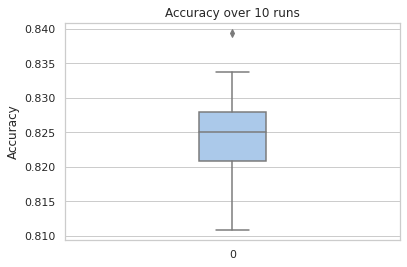

In [ ]:
import seaborn as sns
sns.set(style="whitegrid", palette="pastel")

ax = sns.boxplot(data=x, width=0.2)

ax.set_title("Accuracy over 10 runs")
ax.set_ylabel('Accuracy')